In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df=pd.read_csv("/content/CICIDS2017_sample.csv")

In [ ]:
df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
df.Label.value_counts()

,count
Label,
BENIGN,22731
DoS,19035
PortScan,7946
BruteForce,2767
WebAttack,2180
Bot,1966
Infiltration,36


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56661 entries, 0 to 56660
Data columns (total 78 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flow Duration                56661 non-null  int64  
 1   Total Fwd Packets            56661 non-null  int64  
 2   Total Backward Packets       56661 non-null  int64  
 3   Total Length of Fwd Packets  56661 non-null  int64  
 4   Total Length of Bwd Packets  56661 non-null  int64  
 5   Fwd Packet Length Max        56661 non-null  int64  
 6   Fwd Packet Length Min        56661 non-null  int64  
 7   Fwd Packet Length Mean       56661 non-null  float64
 8   Fwd Packet Length Std        56661 non-null  float64
 9   Bwd Packet Length Max        56661 non-null  int64  
 10  Bwd Packet Length Min        56661 non-null  int64  
 11  Bwd Packet Length Mean       56661 non-null  float64
 12  Bwd Packet Length Std        56661 non-null  float64
 13  Flow Bytes/s    

In [ ]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

In [ ]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [ ]:
X_train.shape

(45328, 77)

In [ ]:
print(np.unique(y_train))  # Check unique class labels
print(y_train.dtype)  # Check data type


[0 1 2 3 4 5 6]
object


In [ ]:
y_train = y_train.astype(int)  # Convert to integer
print(np.unique(y_train), y_train.dtype)  # Check again


[0 1 2 3 4 5 6] int64


In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy={4:1500}) # Create 1500 samples for the minority class "4"

In [ ]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.0 MB/s eta 0:00:00


In [ ]:
import optuna
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import xgboost as xgb

# Common function to train, evaluate and plot heatmap
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_predict)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_predict, average='weighted')

    print(f'Accuracy of {model_name}: {accuracy}')
    print(f'Precision of {model_name}: {precision}')
    print(f'Recall of {model_name}: {recall}')
    print(f'F1-score of {model_name}: {fscore}')
    print(classification_report(y_test, y_predict))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_predict)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f")
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.title(f"Confusion Matrix of {model_name}")
    plt.show()

# Optuna tuning functions
def tune_dt(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }
    model = DecisionTreeClassifier(**params, random_state=0)
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

def tune_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }
    model = RandomForestClassifier(**params, random_state=0)
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

def tune_et(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }
    model = ExtraTreesClassifier(**params, random_state=0)
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

def tune_xg(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }
    model = xgb.XGBClassifier(**params, random_state=0)
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

# Running Optuna
def run_optuna(tune_func, model_name, n_trials=50):
    study = optuna.create_study(direction='maximize')
    study.optimize(tune_func, n_trials=n_trials)
    print(f"Best parameters for {model_name}: {study.best_params}")
    return study.best_params


[I 2025-04-01 17:56:57,931] A new study created in memory with name: no-name-9e8d2943-5b45-4e04-9d02-ae04f7e42a4e
[I 2025-04-01 17:57:02,076] Trial 0 finished with value: 0.9914409247330804 and parameters: {'max_depth': 25, 'min_samples_split': 13, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9914409247330804.
[I 2025-04-01 17:57:09,177] Trial 1 finished with value: 0.9948822024177182 and parameters: {'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9948822024177182.
[I 2025-04-01 17:57:12,717] Trial 2 finished with value: 0.9608223771287391 and parameters: {'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9948822024177182.
[I 2025-04-01 17:57:15,269] Trial 3 finished with value: 0.9944410129709698 and parameters: {'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 

Best parameters for Decision Tree: {'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Accuracy of Decision Tree: 0.995764581311215
Precision of Decision Tree: 0.9957618430285637
Recall of Decision Tree: 0.995764581311215
F1-score of Decision Tree: 0.995759618235671
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.99      0.98      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.71      0.71      0.71         7
           5       0.99      1.00      1.00      1589
           6       0.99      0.98      0.99       436

    accuracy                           1.00     11333
   macro avg       0.95      0.95      0.95     11333
weighted avg       1.00      1.00      1.00     11333



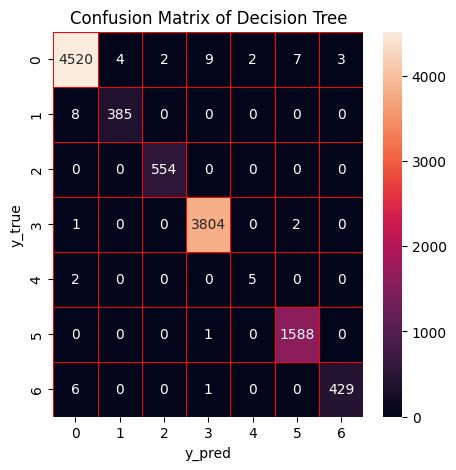

In [ ]:

# Tune and Train Models
best_dt_params = run_optuna(tune_dt, "Decision Tree")
dt = DecisionTreeClassifier(**best_dt_params, random_state=0)
train_and_evaluate(dt, X_train, y_train, X_test, y_test, "Decision Tree")


In [ ]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

[I 2025-04-01 18:00:33,208] A new study created in memory with name: no-name-bdf5437e-27c7-4eb7-9f08-62f3f3f74800
[I 2025-04-01 18:01:14,197] Trial 0 finished with value: 0.9947057266390188 and parameters: {'n_estimators': 300, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9947057266390188.
[I 2025-04-01 18:01:27,201] Trial 1 finished with value: 0.9929409688520251 and parameters: {'n_estimators': 100, 'max_depth': 32, 'min_samples_split': 9, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9947057266390188.
[I 2025-04-01 18:01:37,638] Trial 2 finished with value: 0.9879996470484426 and parameters: {'n_estimators': 100, 'max_depth': 33, 'min_samples_split': 20, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 0 with value: 0.9947057266390188.
[I 2025-04-01 18:02:04,734] Trial 3 finished with value: 0.9939998235242213 and parameters: {'n_estimators': 250, 'max_depth': 21, 'mi

Best parameters for Random Forest: {'n_estimators': 150, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini'}
Accuracy of Random Forest: 0.995764581311215
Precision of Random Forest: 0.9957619483437727
Recall of Random Forest: 0.995764581311215
F1-score of Random Forest: 0.9957394482492445
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4547
           1       0.99      0.97      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.97      0.98       436

    accuracy                           1.00     11333
   macro avg       1.00      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



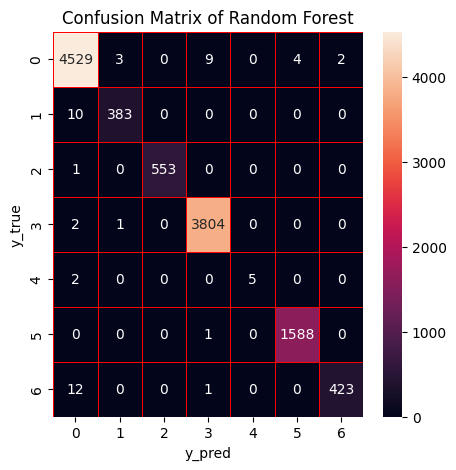

In [ ]:

best_rf_params = run_optuna(tune_rf, "Random Forest")
rf = RandomForestClassifier(**best_rf_params, random_state=0)
train_and_evaluate(rf, X_train, y_train, X_test, y_test, "Random Forest")


In [ ]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

[I 2025-04-01 18:23:53,336] A new study created in memory with name: no-name-9f3370bb-0cec-46c6-b13f-fbd680fe5bd0
[I 2025-04-01 18:24:11,320] Trial 0 finished with value: 0.9601164740139416 and parameters: {'n_estimators': 200, 'max_depth': 44, 'min_samples_split': 6, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 0 with value: 0.9601164740139416.
[I 2025-04-01 18:24:25,606] Trial 1 finished with value: 0.959145857231095 and parameters: {'n_estimators': 300, 'max_depth': 35, 'min_samples_split': 10, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9601164740139416.
[I 2025-04-01 18:24:38,499] Trial 2 finished with value: 0.9553516279890585 and parameters: {'n_estimators': 300, 'max_depth': 36, 'min_samples_split': 16, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 0 with value: 0.9601164740139416.
[I 2025-04-01 18:24:49,744] Trial 3 finished with value: 0.959145857231095 and parameters: {'n_estimators': 250, 'max_depth': 28, 'min_sa

Best parameters for Extra Trees: {'n_estimators': 100, 'max_depth': 48, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini'}
Accuracy of Extra Trees: 0.9906467837289332
Precision of Extra Trees: 0.9906637753823813
Recall of Extra Trees: 0.9906467837289332
F1-score of Extra Trees: 0.9906363061847749
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4547
           1       0.95      0.97      0.96       393
           2       0.98      0.99      0.99       554
           3       0.99      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       0.98      0.96      0.97       436

    accuracy                           0.99     11333
   macro avg       0.96      0.95      0.95     11333
weighted avg       0.99      0.99      0.99     11333



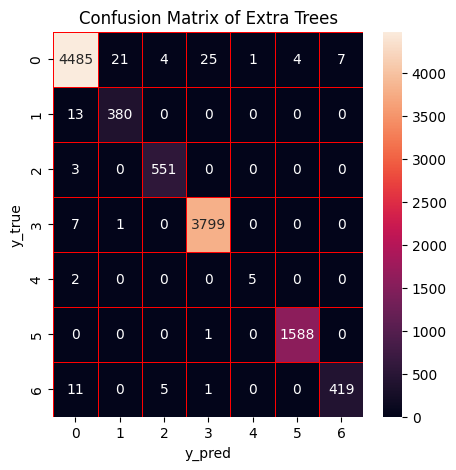

In [ ]:

best_et_params = run_optuna(tune_et, "Extra Trees")
et = ExtraTreesClassifier(**best_et_params, random_state=0)
train_and_evaluate(et, X_train, y_train, X_test, y_test, "Extra Trees")




In [ ]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

[I 2025-04-01 18:29:09,534] A new study created in memory with name: no-name-5eec870b-a886-41e1-b1c7-a5f3b39456bc
[I 2025-04-01 18:29:50,296] Trial 0 finished with value: 0.9975293390982087 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.04969212006898039, 'subsample': 0.5634522762009693, 'colsample_bytree': 0.8419283393310706}. Best is trial 0 with value: 0.9975293390982087.
[I 2025-04-01 18:29:54,955] Trial 1 finished with value: 0.9972646254301597 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2659773577386065, 'subsample': 0.5267824039936269, 'colsample_bytree': 0.8814233794717048}. Best is trial 0 with value: 0.9975293390982087.
[I 2025-04-01 18:30:03,703] Trial 2 finished with value: 0.995235153975117 and parameters: {'n_estimators': 50, 'max_depth': 16, 'learning_rate': 0.020823899416044796, 'subsample': 0.8114273165233206, 'colsample_bytree': 0.5344664204740637}. Best is trial 0 with value: 0.9975293390982087.
[I 2025-04-01 18:

Best parameters for XGBoost: {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.17519070417682112, 'subsample': 0.7419422972148024, 'colsample_bytree': 0.7341756618701339}
Accuracy of XGBoost: 0.9977940527662579
Precision of XGBoost: 0.9977928487216056
Recall of XGBoost: 0.9977940527662579
F1-score of XGBoost: 0.9977764513344796
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       1.00      0.96      0.97     11333
weighted avg       1.00      1.00      1.00     11333



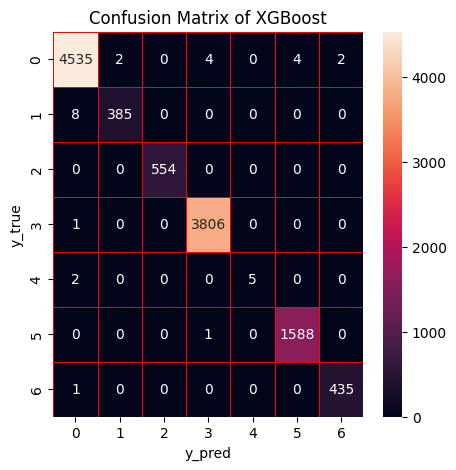

In [ ]:
best_xg_params = run_optuna(tune_xg, "XGBoost")
xg = xgb.XGBClassifier(**best_xg_params, random_state=0)
train_and_evaluate(xg, X_train, y_train, X_test, y_test, "XGBoost")

In [ ]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

In [ ]:
# Use the outputs of 4 base models to construct a new ensemble model
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,5,5,5,5
1,3,3,3,3
2,5,5,5,5
3,3,3,3,3
4,2,2,2,2


In [ ]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [ ]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

In [ ]:
stk = xgb.XGBClassifier().fit(x_train, y_train)

Accuracy of Stacking: 0.9960292949792641
Precision of Stacking: 0.9960511072574638
Recall of Stacking: 0.9960292949792641
F1-score of Stacking: 0.9960211364085831
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.96      0.98      0.97       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       0.99      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



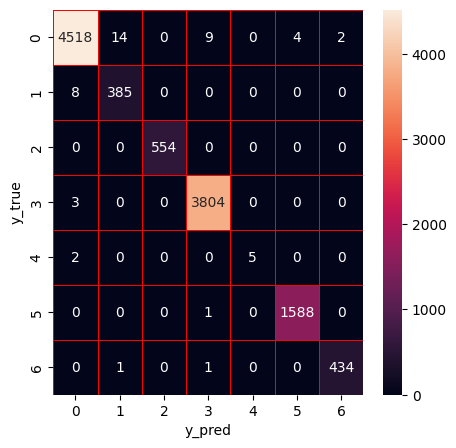

In [ ]:
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Save the feature importance lists generated by four tree-based algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xgb_feature = xg.feature_importances_

In [ ]:
avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature)/4

In [ ]:
feature=(df.drop(['Label'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

Features sorted by their score:
[(np.float64(0.106), 'Bwd Packet Length Min'), (np.float64(0.0844), 'Bwd Packet Length Std'), (np.float64(0.0597), 'Packet Length Mean'), (np.float64(0.0499), 'Init_Win_bytes_forward'), (np.float64(0.0416), 'PSH Flag Count'), (np.float64(0.0336), 'Init_Win_bytes_backward'), (np.float64(0.0313), 'Bwd Packets/s'), (np.float64(0.03), 'Bwd Packet Length Mean'), (np.float64(0.0257), 'Total Backward Packets'), (np.float64(0.0248), 'Average Packet Size'), (np.float64(0.0238), 'Packet Length Std'), (np.float64(0.0236), 'Max Packet Length'), (np.float64(0.0231), 'Avg Bwd Segment Size'), (np.float64(0.0222), 'Fwd Header Length'), (np.float64(0.0199), 'Bwd Packet Length Max'), (np.float64(0.0196), 'Fwd Header Length.1'), (np.float64(0.0195), 'Fwd Packet Length Min'), (np.float64(0.017), 'Total Length of Fwd Packets'), (np.float64(0.0162), 'min_seg_size_forward'), (np.float64(0.0157), 'Fwd IAT Min'), (np.float64(0.0156), 'ACK Flag Count'), (np.float64(0.0154), 'Pack

In [ ]:
f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)

In [ ]:
len(f_list)

77

In [ ]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break

In [ ]:
X_fs = df[fs].values


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [ ]:
X_train.shape

(45328, 40)

In [ ]:
pd.Series(y_train).value_counts()

,count
0,18184
3,15228
5,6357
2,2213
6,1744
1,1573
4,29


In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy={4:1500})

In [ ]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)


In [ ]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
pd.Series(y_train).value_counts()

,count
0,18184
3,15228
5,6357
2,2213
6,1744
1,1573
4,1500


[I 2025-04-01 18:50:40,336] A new study created in memory with name: no-name-ff33b7d4-695d-4c65-838f-696d88648534
[I 2025-04-01 18:50:41,081] Trial 0 finished with value: 0.9902055942821848 and parameters: {'max_depth': 29, 'min_samples_split': 16, 'min_samples_leaf': 18, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9902055942821848.
[I 2025-04-01 18:50:41,783] Trial 1 finished with value: 0.9902055942821848 and parameters: {'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 18, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9902055942821848.
[I 2025-04-01 18:50:42,326] Trial 2 finished with value: 0.9701755933998059 and parameters: {'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 0 with value: 0.9902055942821848.
[I 2025-04-01 18:50:43,039] Trial 3 finished with value: 0.9902055942821848 and parameters: {'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 18, 'criterion': 'entropy'}. Best is trial

Best parameters for Decision Tree: {'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'entropy'}
Accuracy of Decision Tree: 0.9955881055325156
Precision of Decision Tree: 0.9957141241900852
Recall of Decision Tree: 0.9955881055325156
F1-score of Decision Tree: 0.9956361238139685
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4547
           1       0.99      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.50      0.71      0.59         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.98      0.98       436

    accuracy                           1.00     11333
   macro avg       0.92      0.95      0.94     11333
weighted avg       1.00      1.00      1.00     11333



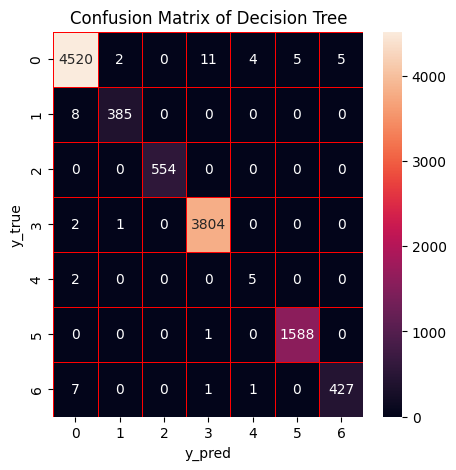

In [ ]:
best_dt_params = run_optuna(tune_dt, "Decision Tree")
dt = DecisionTreeClassifier(**best_dt_params, random_state=0)
train_and_evaluate(dt, X_train, y_train, X_test, y_test, "Decision Tree")


In [ ]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

[I 2025-04-01 18:51:17,194] A new study created in memory with name: no-name-c5d35cf6-678a-4260-9cfa-283552861f88
[I 2025-04-01 18:51:21,610] Trial 0 finished with value: 0.990999735286332 and parameters: {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 0 with value: 0.990999735286332.
[I 2025-04-01 18:51:31,212] Trial 1 finished with value: 0.9894996911673872 and parameters: {'n_estimators': 100, 'max_depth': 45, 'min_samples_split': 6, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 0 with value: 0.990999735286332.
[I 2025-04-01 18:51:50,717] Trial 2 finished with value: 0.9947057266390188 and parameters: {'n_estimators': 250, 'max_depth': 46, 'min_samples_split': 6, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 2 with value: 0.9947057266390188.
[I 2025-04-01 18:52:09,882] Trial 3 finished with value: 0.9875584576016941 and parameters: {'n_estimators': 200, 'max_depth': 48, 'min_sam

Best parameters for Random Forest: {'n_estimators': 200, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'gini'}
Accuracy of Random Forest: 0.9966469602047119
Precision of Random Forest: 0.9966311723234895
Recall of Random Forest: 0.9966469602047119
F1-score of Random Forest: 0.9966332480443414
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.98      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.98      0.99       436

    accuracy                           1.00     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       1.00      1.00      1.00     11333



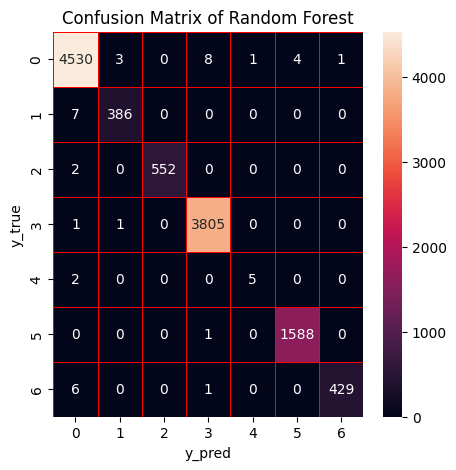

In [ ]:

best_rf_params = run_optuna(tune_rf, "Random Forest")
rf = RandomForestClassifier(**best_rf_params, random_state=0)
train_and_evaluate(rf, X_train, y_train, X_test, y_test, "Random Forest")


In [ ]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

[I 2025-04-01 19:06:16,064] A new study created in memory with name: no-name-33f35acd-b0c6-460e-a242-4592e1089c74
[I 2025-04-01 19:06:17,650] Trial 0 finished with value: 0.9691167387276096 and parameters: {'n_estimators': 50, 'max_depth': 26, 'min_samples_split': 15, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 0 with value: 0.9691167387276096.
[I 2025-04-01 19:06:20,028] Trial 1 finished with value: 0.9307332568604959 and parameters: {'n_estimators': 100, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9691167387276096.
[I 2025-04-01 19:06:21,431] Trial 2 finished with value: 0.9557045795464573 and parameters: {'n_estimators': 50, 'max_depth': 44, 'min_samples_split': 12, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9691167387276096.
[I 2025-04-01 19:06:25,156] Trial 3 finished with value: 0.956057531103856 and parameters: {'n_estimators': 100, 'max_depth': 19, 'min_

Best parameters for Extra Trees: {'n_estimators': 150, 'max_depth': 48, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini'}
Accuracy of Extra Trees: 0.995764581311215
Precision of Extra Trees: 0.9957574742877291
Recall of Extra Trees: 0.995764581311215
F1-score of Extra Trees: 0.9957561519125192
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.97      0.98      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.97      0.95      0.96     11333
weighted avg       1.00      1.00      1.00     11333



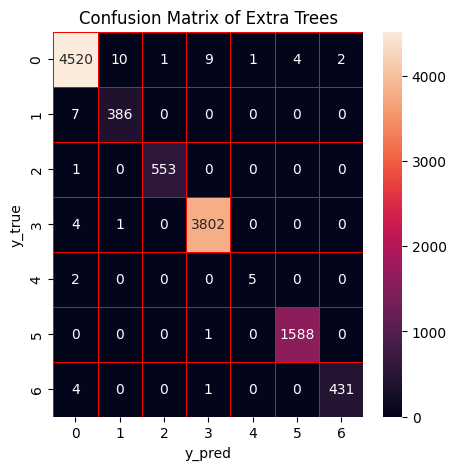

In [ ]:
best_et_params = run_optuna(tune_et, "Extra Trees")
et = ExtraTreesClassifier(**best_et_params, random_state=0)
train_and_evaluate(et, X_train, y_train, X_test, y_test, "Extra Trees")



In [ ]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

[I 2025-04-01 19:12:22,274] A new study created in memory with name: no-name-37e8e122-41a2-4bd2-b47c-38b094043415
[I 2025-04-01 19:12:24,748] Trial 0 finished with value: 0.9863231271507985 and parameters: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.06444353399557184, 'subsample': 0.848170023437839, 'colsample_bytree': 0.5161956311030352}. Best is trial 0 with value: 0.9863231271507985.
[I 2025-04-01 19:12:44,798] Trial 1 finished with value: 0.9975293390982087 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2792133834493082, 'subsample': 0.8815619599604977, 'colsample_bytree': 0.8902067569603009}. Best is trial 1 with value: 0.9975293390982087.
[I 2025-04-01 19:13:06,321] Trial 2 finished with value: 0.9973528633195095 and parameters: {'n_estimators': 250, 'max_depth': 13, 'learning_rate': 0.03273987053367189, 'subsample': 0.7473198514041339, 'colsample_bytree': 0.7068950104822298}. Best is trial 1 with value: 0.9975293390982087.
[I 2025-04-01 19:

Best parameters for XGBoost: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.17427339391549376, 'subsample': 0.9559638897369797, 'colsample_bytree': 0.5334801203426525}
Accuracy of XGBoost: 0.9981470043236566
Precision of XGBoost: 0.9981326025873692
Recall of XGBoost: 0.9981470043236566
F1-score of XGBoost: 0.9981364312175266
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      0.99      0.99       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       0.83      0.71      0.77         7
           5       1.00      1.00      1.00      1589
           6       1.00      1.00      1.00       436

    accuracy                           1.00     11333
   macro avg       0.97      0.96      0.97     11333
weighted avg       1.00      1.00      1.00     11333



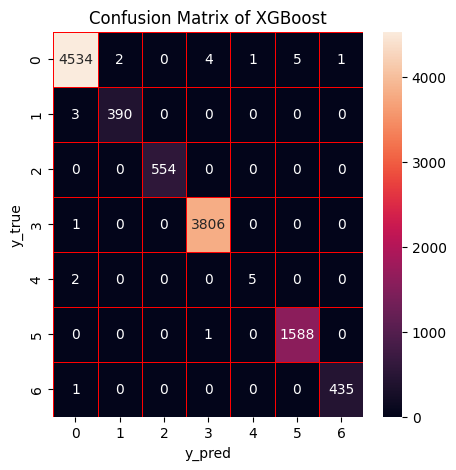

In [ ]:
best_xg_params = run_optuna(tune_xg, "XGBoost")
xg = xgb.XGBClassifier(**best_xg_params, random_state=0)
train_and_evaluate(xg, X_train, y_train, X_test, y_test, "XGBoost")

In [ ]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

In [ ]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,5,5,5,5
1,3,3,3,3
2,5,5,5,5
3,3,3,3,3
4,2,2,2,2


In [ ]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [ ]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9960292949792641
Precision of Stacking: 0.9961694697650314
Recall of Stacking: 0.9960292949792641
F1-score of Stacking: 0.996084268194693
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.97      0.98      0.98       393
           2       0.99      1.00      0.99       554
           3       1.00      1.00      1.00      3807
           4       0.50      0.71      0.59         7
           5       1.00      1.00      1.00      1589
           6       1.00      0.99      0.99       436

    accuracy                           1.00     11333
   macro avg       0.92      0.95      0.94     11333
weighted avg       1.00      1.00      1.00     11333



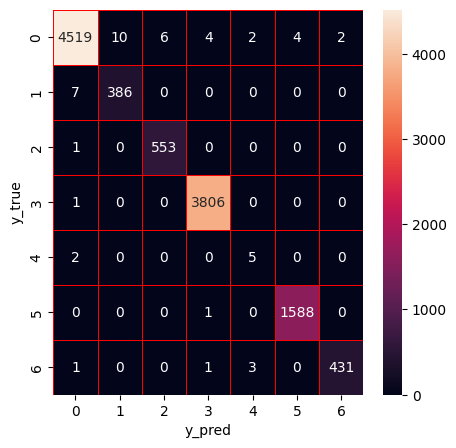

In [ ]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()